In [2]:
import sys
sys.path.append('..')
from clf_funcs import setup
from load_datasets import load_image, show_image_with_bbox
from sodnet_funcs import ResBlock, SODNetBuilder, get_adam_loaders

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf

setup()

2023-12-27 01:26:49.491888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 01:26:51.394600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 01:26:51.398808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-

In [2]:
root = '../../datasets/ADAM/Training1200'
fovea = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')

display(fovea.head())
display(fovea.tail())

,imgName,Fovea_X,Fovea_Y
ID,,,
0,A0001.jpg,142.495130,127.255264
1,A0001-1.jpg,173.229593,152.780556
2,A0001-2.jpg,142.495130,127.255264
3,A0002.jpg,116.640789,126.623708
4,A0002-1.jpg,116.640789,129.376292


,imgName,Fovea_X,Fovea_Y
ID,,,
1180,N0310-1.jpg,121.887742,147.226449
1181,N0310-2.jpg,121.887742,147.226449
1182,N0311.jpg,132.273929,134.670017
1183,N0311-1.jpg,132.273929,134.670017
1184,N0311-2.jpg,132.273929,134.670017


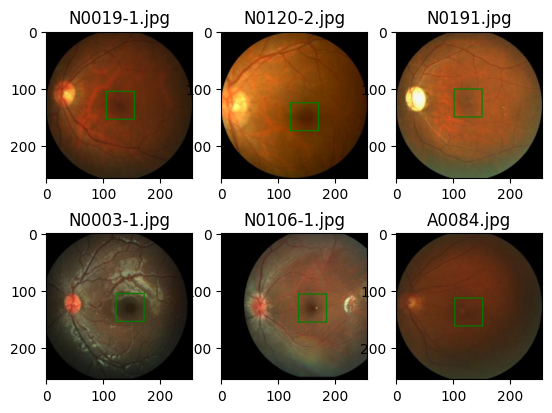

In [3]:
fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(fovea.index, size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = load_image(fovea, idx, root=root)
	show_image_with_bbox(fovea, img, bbox, ax=ax, idx=idx)

In [4]:
train_ds, test_ds = get_adam_loaders(8, 16, cutoff=0.8)
img_batch, bbox_batch = next(iter(train_ds))
print(img_batch.shape, img_batch.dtype)
print(bbox_batch, bbox_batch.dtype)

2023-12-25 01:26:06.289312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 01:26:06.289949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 01:26:06.290425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(8, 256, 256, 3) <dtype: 'float32'>
tf.Tensor(
[[0.55619925 0.6935127 ]
 [0.5217791  0.50629   ]
 [0.48410583 0.53718513]
 [0.5138706  0.5114322 ]
 [0.5281234  0.5507991 ]
 [0.4698848  0.4965707 ]
 [0.48856217 0.50809574]
 [0.5067911  0.5463664 ]], shape=(8, 2), dtype=float32) <dtype: 'float32'>


In [5]:
resblock = ResBlock(3, 16)
resblock.build(input_shape=(None, 256, 256, 3))
resblock.summary()

Model: "res_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       96        
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 16)      512       
                                                                 
Total params: 608 (2.38 KB)
Trainable params: 570 (2.23 KB)
Non-trainable params: 38 (152.00 Byte)
_________________________________________________________________


In [6]:
model = SODNetBuilder(3, 16)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block_1 (ResBlock)      (None, 256, 256, 16)      608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 res_block_2 (ResBlock)      (None, 128, 128, 32)      7152      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 res_block_3 (ResBlock)      (None, 64, 64, 64)        28128     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)      

In [7]:
loss_func = tf.losses.Huber(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss_func) # no iou metric, proof it works in pytorch :)
epochs = 30
batch = next(iter(train_ds))
model(batch[0])

2023-12-25 01:26:39.857572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[ 0.0934014 , -0.06100543],
       [ 0.0499464 ,  0.00522608],
       [ 0.00202313,  0.03321408],
       [ 0.1482614 , -0.069475  ],
       [ 0.06740537,  0.01738925],
       [ 0.0832203 , -0.01046451],
       [ 0.09378511, -0.0376377 ],
       [ 0.0521117 , -0.02740115]], dtype=float32)>

In [8]:
train_history = model.fit(
	train_ds,
	epochs=epochs,
	shuffle=True,
	validation_data=test_ds
)

Epoch 1/30


2023-12-25 01:26:53.554367: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fce02a79e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-25 01:26:53.554448: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-12-25 01:26:54.028902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-25 01:26:55.877952: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 [==============================] - 21s 79ms/step - loss: 0.1220 - val_loss: 0.0038
Epoch 2/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0655 - val_loss: 0.0077
Epoch 3/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0548 - val_loss: 0.0299
Epoch 4/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0405 - val_loss: 0.0233
Epoch 5/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0341 - val_loss: 0.0348
Epoch 6/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0273 - val_loss: 0.0238
Epoch 7/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0233 - val_loss: 0.0321
Epoch 8/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0233 - val_loss: 0.0244
Epoch 9/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0212 - val_loss: 0.0253
Epoch 10/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0152 - val_loss: 0.0226

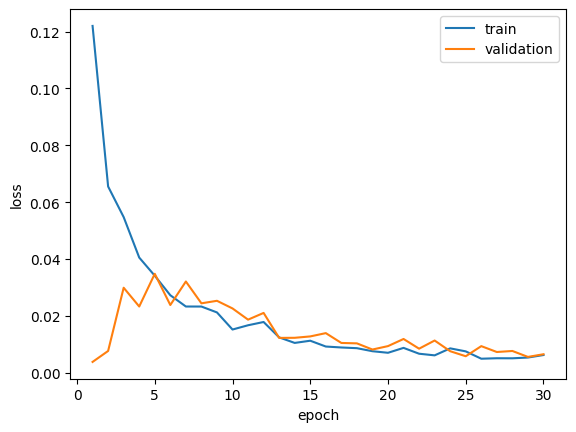

In [9]:
plt.plot([i for i in range(1, epochs+1)], train_history.history['loss'], label='train')
plt.plot([i for i in range(1, epochs+1)], train_history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [15]:
model.evaluate(
	test_ds,
	batch_size=16
)

 1/15 [=>............................] - ETA: 0s - loss: 0.0055

15/15 [==============================] - 0s 31ms/step - loss: 0.0065


0.006512053310871124

In [3]:
from clf_funcs import PerfCounterCallback

def train_sodnet(config, telemetry, child_conn):
	print(f'Benchmarks for SODNet begin')
	# setup()

	train_ds, test_ds = get_adam_loaders(config['batch_size_SOD'], config['test_batch_size_SOD'], cutoff=0.8)
	model = SODNetBuilder(3, 16)
	optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
	model.compile(optimizer=optimizer, loss=config['loss_func_SOD'])
	perfcounter = PerfCounterCallback(telemetry)

	train_history = model.fit(
		train_ds,
		epochs=config['epochs'],
		shuffle=True,
		callbacks=[perfcounter]
	)
	
	telemetry['model_name'].extend(['SODNet'] * config['epochs'])
	telemetry['type'].extend(['training'] * config['epochs'])
	telemetry['loss'].extend(train_history.history['loss'])
	telemetry['performance'].append(-1) # no validation to so as to be comparable to pytorch
	# epoch and elapsed_time handeled by PerfCounterCallback

	eval_history = model.evaluate(
		test_ds,
		batch_size=config['test_batch_size_SOD'],
		callbacks=[perfcounter]
	)

	telemetry['model_name'].append('SODNet')
	telemetry['type'].append('detection')
	telemetry['loss'].append(eval_history)
	telemetry['performance'].append(-1)
	# epoch and elapsed_time handeled by PerfCounterCallback

	# child_conn.send(telemetry)
	return telemetry
	# pd.DataFrame(telemetry).to_csv(config['results_filename'], index=False)

	del model, train_ds, test_ds, train_history, eval_history

In [4]:
telemetry = {
	'model_name': [],
	'type': [],
	'epoch': [],
	'loss': [],
	'performance': [],
	'elapsed_time': []
}

config = {
	'batch_size_SOD': 8,
	'test_batch_size_SOD': 16,
	'epochs': 8,
	'lr': 1e-4,
	'loss_func_SOD': tf.losses.Huber(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE),
	'silent': False,
}

telemetry = train_sodnet(config, telemetry, None)

Benchmarks for SODNet begin


2023-12-27 01:27:06.158889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 01:27:06.159091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 01:27:06.159223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/8


2023-12-27 01:27:11.488243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-27 01:27:12.674594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb096cc4310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-27 01:27:12.674618: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-12-27 01:27:12.678593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-27 01:27:12.785538: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 [==============================] - 15s 57ms/step - loss: 0.1097
Epoch 2/8
119/119 [==============================] - 5s 46ms/step - loss: 0.0696
Epoch 3/8
119/119 [==============================] - 6s 47ms/step - loss: 0.0469
Epoch 4/8
119/119 [==============================] - 5s 46ms/step - loss: 0.0380
Epoch 5/8
119/119 [==============================] - 6s 47ms/step - loss: 0.0335
Epoch 6/8
119/119 [==============================] - 6s 47ms/step - loss: 0.0282
Epoch 7/8
119/119 [==============================] - 6s 47ms/step - loss: 0.0285
Epoch 8/8
15/15 [==============================] - 3s 85ms/step - loss: 0.0276


In [8]:
for k in telemetry:
	print(k, len(telemetry[k]))

model_name 9
type 9
epoch 9
loss 9
performance 2
elapsed_time 9


: 